In [1]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5 statsmodels rich
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from rich.progress import track

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


In [2]:
lcpm = (
    pl.read_csv(
        "../results/lcpm.tsv",
        separator="\t",
    )
    .rename({"gene": "gene_id"})
    .group_by("gene_id")
    .agg(pl.col("lcpm").mean().alias("lcpm"))
)

From that Zhang paper, looks like I should be calculating methylation across exons, as transposable element inserts can mess up mean methylation values.

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_17651/1138032415.py:46: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["gene_id", "column_3", "type"])


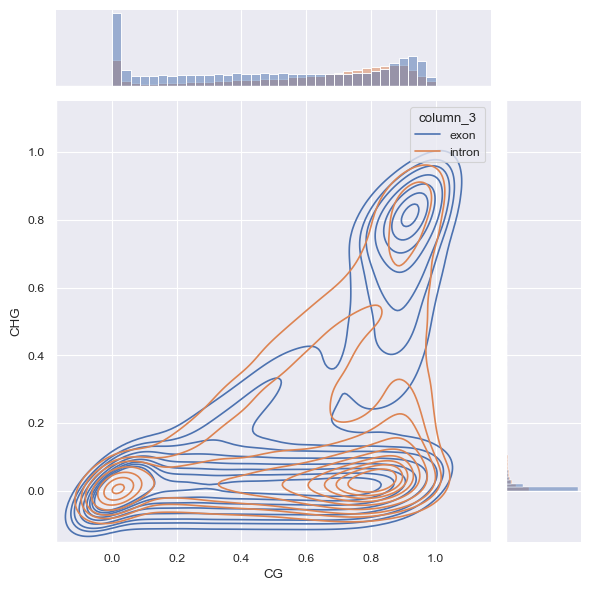

In [19]:
cg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        pl.col("column_9").str.extract(r"gene_id=(.*?);").alias("gene_id"),
        (pl.col("column_10").cast(pl.Float32, strict=False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CG").alias("type"),
    )
)

chg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        pl.col("column_9").str.extract(r"gene_id=(.*?);").alias("gene_id"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHG").alias("type"),
    )
)

chh_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHH.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        pl.col("column_9").str.extract(r"gene_id=(.*?);").alias("gene_id"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHH").alias("type"),
    )
)

methylation = pl.concat([cg_methylation, chg_methylation, chh_methylation])

# Get average exon methylation per gene
subfeature_methylation = (
    methylation
    .filter(pl.col("column_3").str.contains("exon|intron"))
    .groupby(["gene_id", "column_3", "type"])
    .agg(
        (pl.col("weighted_mean").sum() / pl.col("column_11").sum()).alias("weighted_mean")
    )
)

g = sns.JointGrid(
    (
        subfeature_methylation
        .filter(pl.col("column_3") == "exon")
        .pivot(index=["gene_id"], columns="type", values="weighted_mean") 
    ),
    x="CG",
    y="CHG",
)
g.plot_joint(sns.kdeplot)
g.plot_marginals(sns.histplot)